In [1]:
%load_ext autoreload
%autoreload 2

# Outlier detection

The dataset contains a large number of samples that are trivially wrong: only by considering the points whose latitude and longitude fall approximately in the New York City area, several samples can be removed. This leads to the possibility that also in New York City there are several point that can be removed.

In [2]:
import matplotlib.pyplot as plt
import polars as pl
import os.path
import seaborn as sns
import numpy as np
import math
import tensorflow as tf

import taxifare.data as data
import taxifare.boroughs as boroughs
import taxifare.preprocess as preprocess

2023-06-27 16:36:47.244067: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-27 16:36:47.330182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 16:36:47.477660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-27 16:36:47.478239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 16:36:48.563620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
DF_FILENAME = 'datasets/outlier_detection.parquet'
samples = 5_000_000

# Load dataset for this notebook from file if found, generate on the
# spot otherwise
if os.path.exists(DF_FILENAME):
    df = pl.scan_csv(DF_FILENAME).fetch(samples)
else:
    namespace = preprocess.Namespace()
    namespace.input_path = data.DATASET_PATH
    namespace.samples = samples
    namespace.preprocessing_flags = preprocess.PreprocessingFlags.TIME_FEATURES
    df = preprocess.preprocess(namespace)

print(df.shape)
df.head()

(5000000, 12)


shape: (5, 12)
┌─────────────┬────────────┬────────────┬───────────────┬───┬─────────┬──────┬───────────┬─────────┐
│ fare_amount ┆ pickup_lon ┆ pickup_lat ┆ dropoff_longi ┆ … ┆ weekday ┆ hour ┆ after2012 ┆ weekend │
│ ---         ┆ gitude     ┆ itude      ┆ tude          ┆   ┆ ---     ┆ ---  ┆ ---       ┆ ---     │
│ f64         ┆ ---        ┆ ---        ┆ ---           ┆   ┆ u32     ┆ u32  ┆ bool      ┆ bool    │
│             ┆ f64        ┆ f64        ┆ f64           ┆   ┆         ┆      ┆           ┆         │
╞═════════════╪════════════╪════════════╪═══════════════╪═══╪═════════╪══════╪═══════════╪═════════╡
│ 4.5         ┆ -73.844311 ┆ 40.721319  ┆ -73.84161     ┆ … ┆ 1       ┆ 17   ┆ false     ┆ false   │
│ 16.9        ┆ -74.016048 ┆ 40.711303  ┆ -73.979268    ┆ … ┆ 2       ┆ 16   ┆ false     ┆ false   │
│ 5.7         ┆ -73.982738 ┆ 40.76127   ┆ -73.991242    ┆ … ┆ 4       ┆ 0    ┆ false     ┆ false   │
│ 7.7         ┆ -73.98713  ┆ 40.733143  ┆ -73.991567    ┆ … ┆ 6       ┆ 4    ┆ false     ┆ true    │
│ 5.3         ┆ -73.968095 ┆ 40.768008  ┆ -73.956655    ┆ … ┆ 2       ┆ 7    ┆ false     ┆ false   │
└─────────────┴────────────┴────────────┴───────────────┴───┴─────────┴──────┴───────────┴─────────┘

In [4]:
describe_infos = df.describe()
describe_infos

shape: (9, 13)
┌──────────┬───────────┬────────────┬────────────┬───┬──────────┬───────────┬───────────┬──────────┐
│ describe ┆ fare_amou ┆ pickup_lon ┆ pickup_lat ┆ … ┆ weekday  ┆ hour      ┆ after2012 ┆ weekend  │
│ ---      ┆ nt        ┆ gitude     ┆ itude      ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---      │
│ str      ┆ ---       ┆ ---        ┆ ---        ┆   ┆ f64      ┆ f64       ┆ f64       ┆ f64      │
│          ┆ f64       ┆ f64        ┆ f64        ┆   ┆          ┆           ┆           ┆          │
╞══════════╪═══════════╪════════════╪════════════╪═══╪══════════╪═══════════╪═══════════╪══════════╡
│ count    ┆ 5e6       ┆ 5e6        ┆ 5e6        ┆ … ┆ 5e6      ┆ 5e6       ┆ 5e6       ┆ 5e6      │
│ null_cou ┆ 0.0       ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0      ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ nt       ┆           ┆            ┆            ┆   ┆          ┆           ┆           ┆          │
│ mean     ┆ 11.321693 ┆ -73.97541  ┆ 40.75086   ┆ … ┆ 4.042004 ┆ 13.510306 ┆ 0.4281736 ┆ 0.283083 │
│ std      ┆ 9.644242  ┆ 0.035001   ┆ 0.027087   ┆ … ┆ 1.949477 ┆ 6.515681  ┆ 0.494833  ┆ 0.451419 │
│ min      ┆ -62.0     ┆ -74.268058 ┆ 40.507085  ┆ … ┆ 1.0      ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ max      ┆ 952.0     ┆ -73.070073 ┆ 41.129695  ┆ … ┆ 7.0      ┆ 23.0      ┆ 1.0       ┆ 1.0      │
│ median   ┆ 8.5       ┆ -73.982103 ┆ 40.753342  ┆ … ┆ 4.0      ┆ 14.0      ┆ 0.0       ┆ 0.0      │
│ 25%      ┆ 6.0       ┆ -73.992273 ┆ 40.736551  ┆ … ┆ 2.0      ┆ 9.0       ┆ null      ┆ null     │
│ 75%      ┆ 12.5      ┆ -73.96835  ┆ 40.767515  ┆ … ┆ 6.0      ┆ 19.0      ┆ null      ┆ null     │
└──────────┴───────────┴────────────┴────────────┴───┴──────────┴───────────┴───────────┴──────────┘

### Passenger count
According to the [NYC taxi commission](https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated) the maximum number of passengers, for suitable vehicles, is five. An additional sixth person (child) is admitted. Thus, it is possible to consider all samples that exceed the number of six passengers to be noise. In fact, values greater than six are highly underrepresented.

In [5]:
df.groupby('passenger_count').agg(pl.count()).sort('passenger_count')

shape: (10, 2)
┌─────────────────┬─────────┐
│ passenger_count ┆ count   │
│ ---             ┆ ---     │
│ i64             ┆ u32     │
╞═════════════════╪═════════╡
│ 1               ┆ 3470419 │
│ 2               ┆ 741834  │
│ 3               ┆ 220220  │
│ 4               ┆ 106555  │
│ …               ┆ …       │
│ 7               ┆ 1       │
│ 9               ┆ 2       │
│ 129             ┆ 1       │
│ 208             ┆ 2       │
└─────────────────┴─────────┘

In [6]:
df = df.filter(pl.col('passenger_count') <= 6)

## Analyzing spatial locations
Thanks to [1] we can download a map of New York City that help us visualyze the pickup and dropoff locations.
There are several style that can be used but for our purposes is useful to have a map without any label or decoration.

To download the image of the map we have to give a bounding box of the area we wanto to download, for visualization purposes we chose to use a square bounding box (mind that a square in a sphere is not a square in a plane so there are additional steps to do).

Using cached image


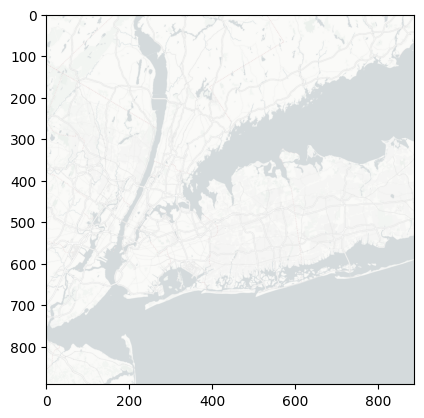

(-74.268058, -73.05, 40.35531951805295, 41.281433481947055)


In [7]:
max_values = describe_infos.filter(pl.col('describe') == 'max').select(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
min_values = describe_infos.filter(pl.col('describe') == 'min').select(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
x_max = max(max_values['pickup_longitude'][0], max_values['dropoff_longitude'][0])
y_max = max(max_values['pickup_latitude'][0], max_values['dropoff_latitude'][0])
x_min = min(min_values['pickup_longitude'][0], min_values['dropoff_longitude'][0])
y_min = min(min_values['pickup_latitude'][0], min_values['dropoff_latitude'][0])

# Make the area a square
width = data.distance((x_min,y_min), (x_max,y_min))
height = data.distance((x_min,y_min), (x_min,y_max))

assert width > height

additional_space = (width - height)/2

new_lat_min, _ = data.find_latitude_correction((x_min,y_min), additional_space, b=-1)
new_lat_max, _ = data.find_latitude_correction((x_min,y_max), additional_space, b=1)

points_area = x_min, x_max, new_lat_min, new_lat_max

url = 'https://b.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
image = data.new_york_map(points_area)

plt.imshow(image)
plt.show()
print(points_area)

## Detecting point on the ocean - Oceanic detection
Now that we have a map of New York City we can use the image as a mask to filter out the points that falls into the ocean

In [8]:
# Remove points on ocean, not working at the moment
ocean_pickup = df.select(
    pl.struct(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    .map(data.polars_point_on_ocean(points_area, pickup=True))
    ).get_columns()[0].alias('ocean_pickup')
ocean_dropoff = df.select(
    pl.struct(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'])
    .map(data.polars_point_on_ocean(points_area, dropoff=True))
    ).get_columns()[0].alias('ocean_dropoff')

print('Pickups in the ocean', ocean_pickup.arg_true().shape[0])
print('Dropoffs in the ocean', ocean_dropoff.arg_true().shape[0])
print('Total ocean outlier samples',
      (ocean_dropoff | ocean_pickup).arg_true().shape[0])

outsiders_pickup = df.filter(ocean_pickup)
outsiders_dropoff = df.filter(ocean_dropoff)

100%|██████████| 4999994/4999994 [00:07<00:00, 670854.06it/s]


Pickups in the ocean 10347
Dropoffs in the ocean 14606
Total ocean outlier samples 22667


In [9]:
def print_point_on_map(ax, x, y, points_area, image, markersize=.5, color='b', title=None):
    left, right, bottom, top = points_area
    ax.imshow(image, extent=(left, right, bottom, top))
    ax.set_ylim(bottom, top)
    ax.set_xlim(left, right)
    ax.scatter(x, y, markersize, color)
    if title is not None:
        ax.title.set_text(str(title))

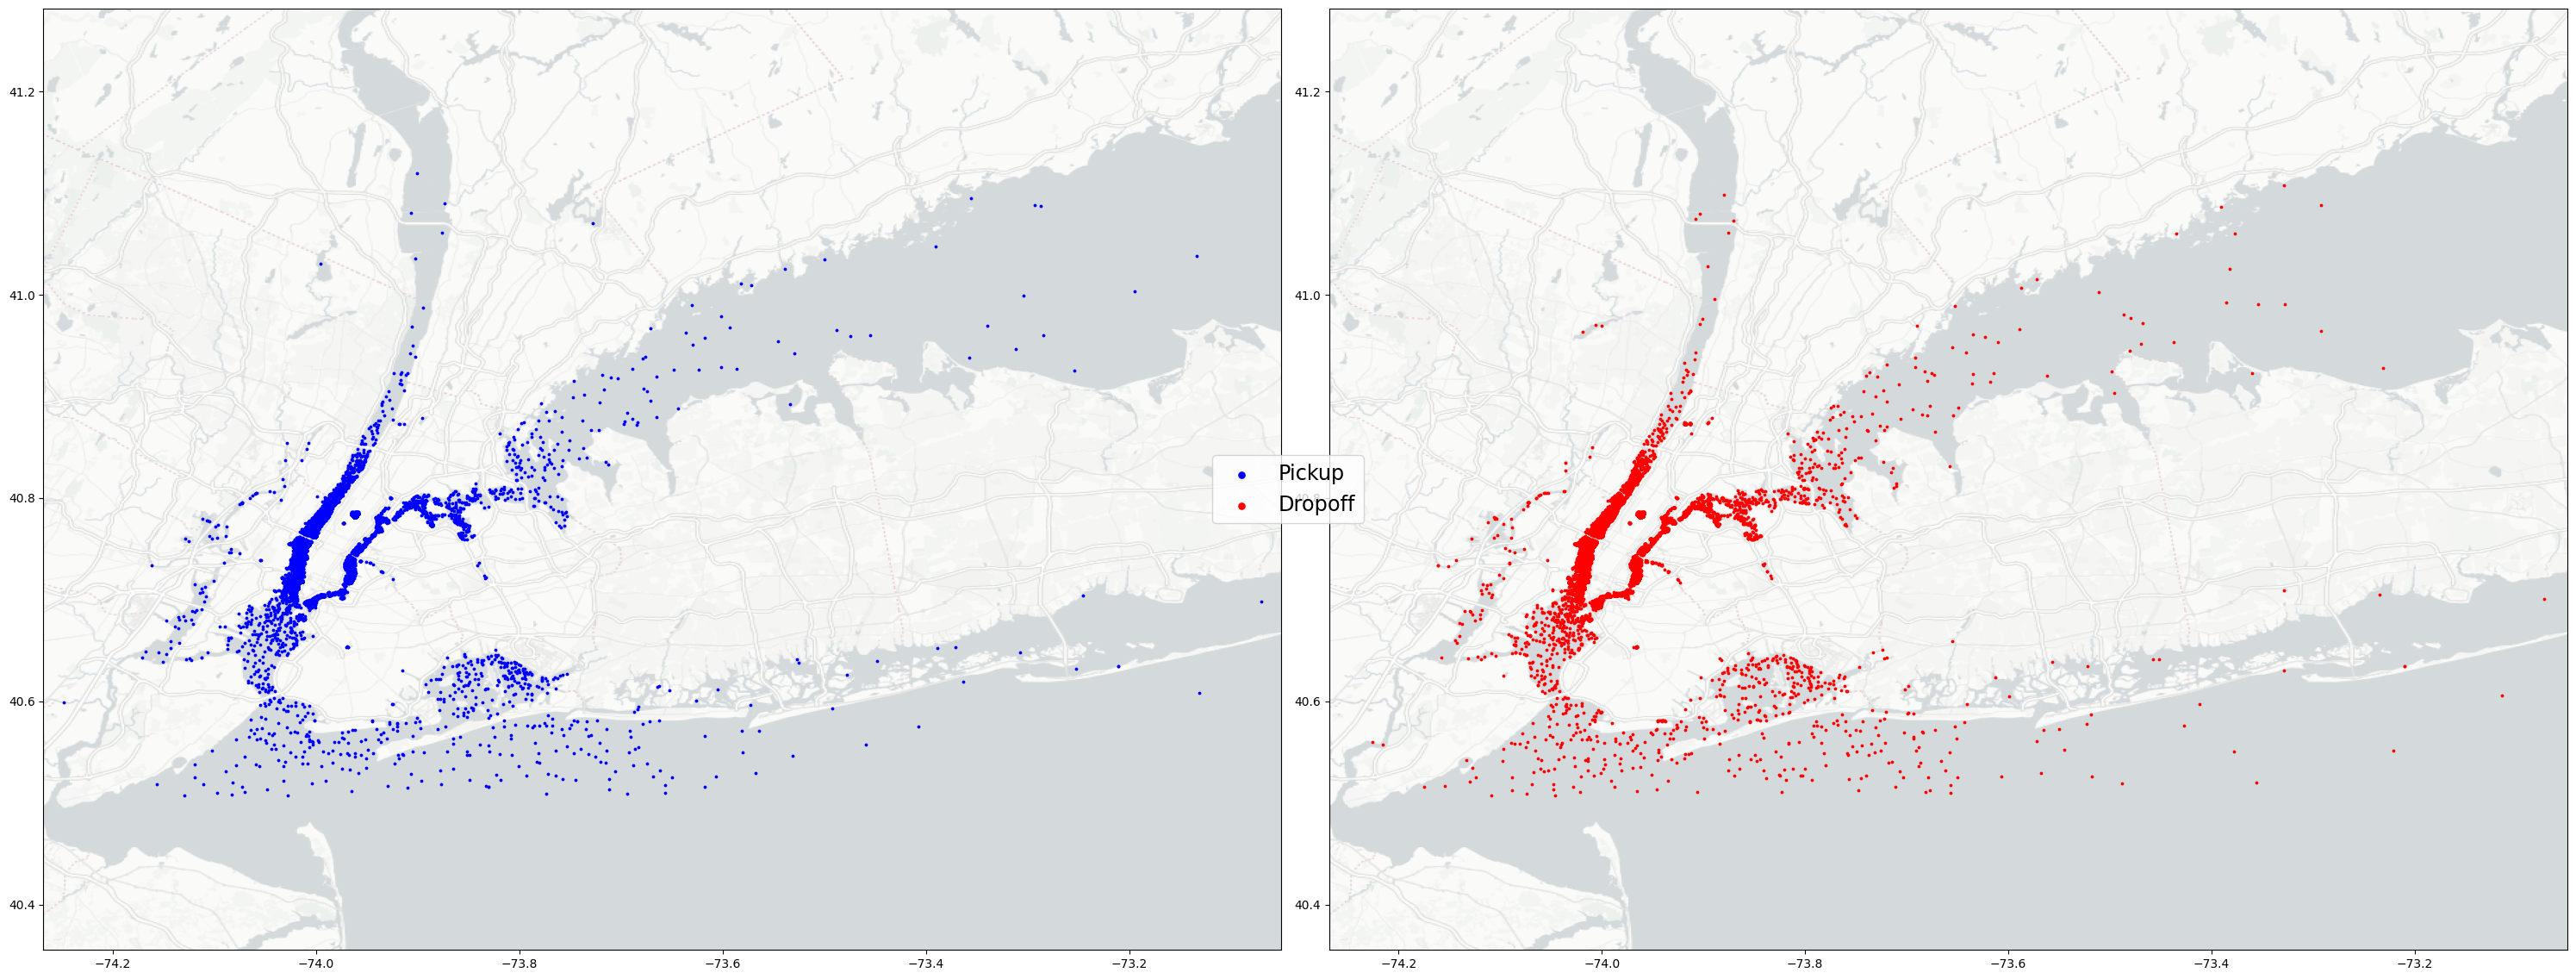

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(30, 30))

print_point_on_map(axs[0], outsiders_pickup['pickup_longitude'], outsiders_pickup['pickup_latitude'], points_area, image, color='b', markersize=3)
print_point_on_map(axs[1], outsiders_dropoff['dropoff_longitude'], outsiders_dropoff['dropoff_latitude'], points_area, image, color='r', markersize=3)
fig.legend(('Pickup', 'Dropoff'), fontsize='xx-large', loc='center',
           markerscale=3)

plt.tight_layout()
plt.show()

In [11]:
df = df.filter(~ocean_pickup & ~ocean_dropoff)

## Detectiong point outside boroughs

Analyzing the dataset we noticed that the fee for the taxi also depends on the boroughs the pickup and dropoff location are. Noticing this fact we also included the boroughs and neighborhood of pickup and dropoff as a feature. Now that we have geographical information of boroughs we can remove additional outliers that are outside the area of New York City.

This method makes the first oceanic detection usless because now we have a better filter but we decided to keep in this notebook that implementation anyway

Thanks to [2] we filtered the samples that have pickup or dropoff outside the boroughs of New York City.

Using the areas as polygons leads us to use low performance function to check if a point is inside a non convex shape. We can "compile" the polygons into an image and use it as an array to get the value associated to a position (similar to the oceanic detection). This increased the performance by 10x.

In [12]:
boros = boroughs.load()

In [13]:
boros_image, boros_colors = boroughs.get_image_boroughs(boros, points_area)

df = df.with_columns(pl.struct(['pickup_longitude', 'pickup_latitude'])
                       .map(boroughs.point_boroughs(boros_image, boros_colors, points_area, "pickup_")).alias('pickup_borough'))

df = df.with_columns(pl.struct(['dropoff_longitude', 'dropoff_latitude'])
                       .map(boroughs.point_boroughs(boros_image, boros_colors, points_area, "dropoff_")).alias('dropoff_borough'))

100%|██████████| 4977327/4977327 [00:11<00:00, 422632.65it/s]


In [14]:
df = df.filter((pl.col('pickup_borough') != 'None') & (pl.col('dropoff_borough') != 'None'))

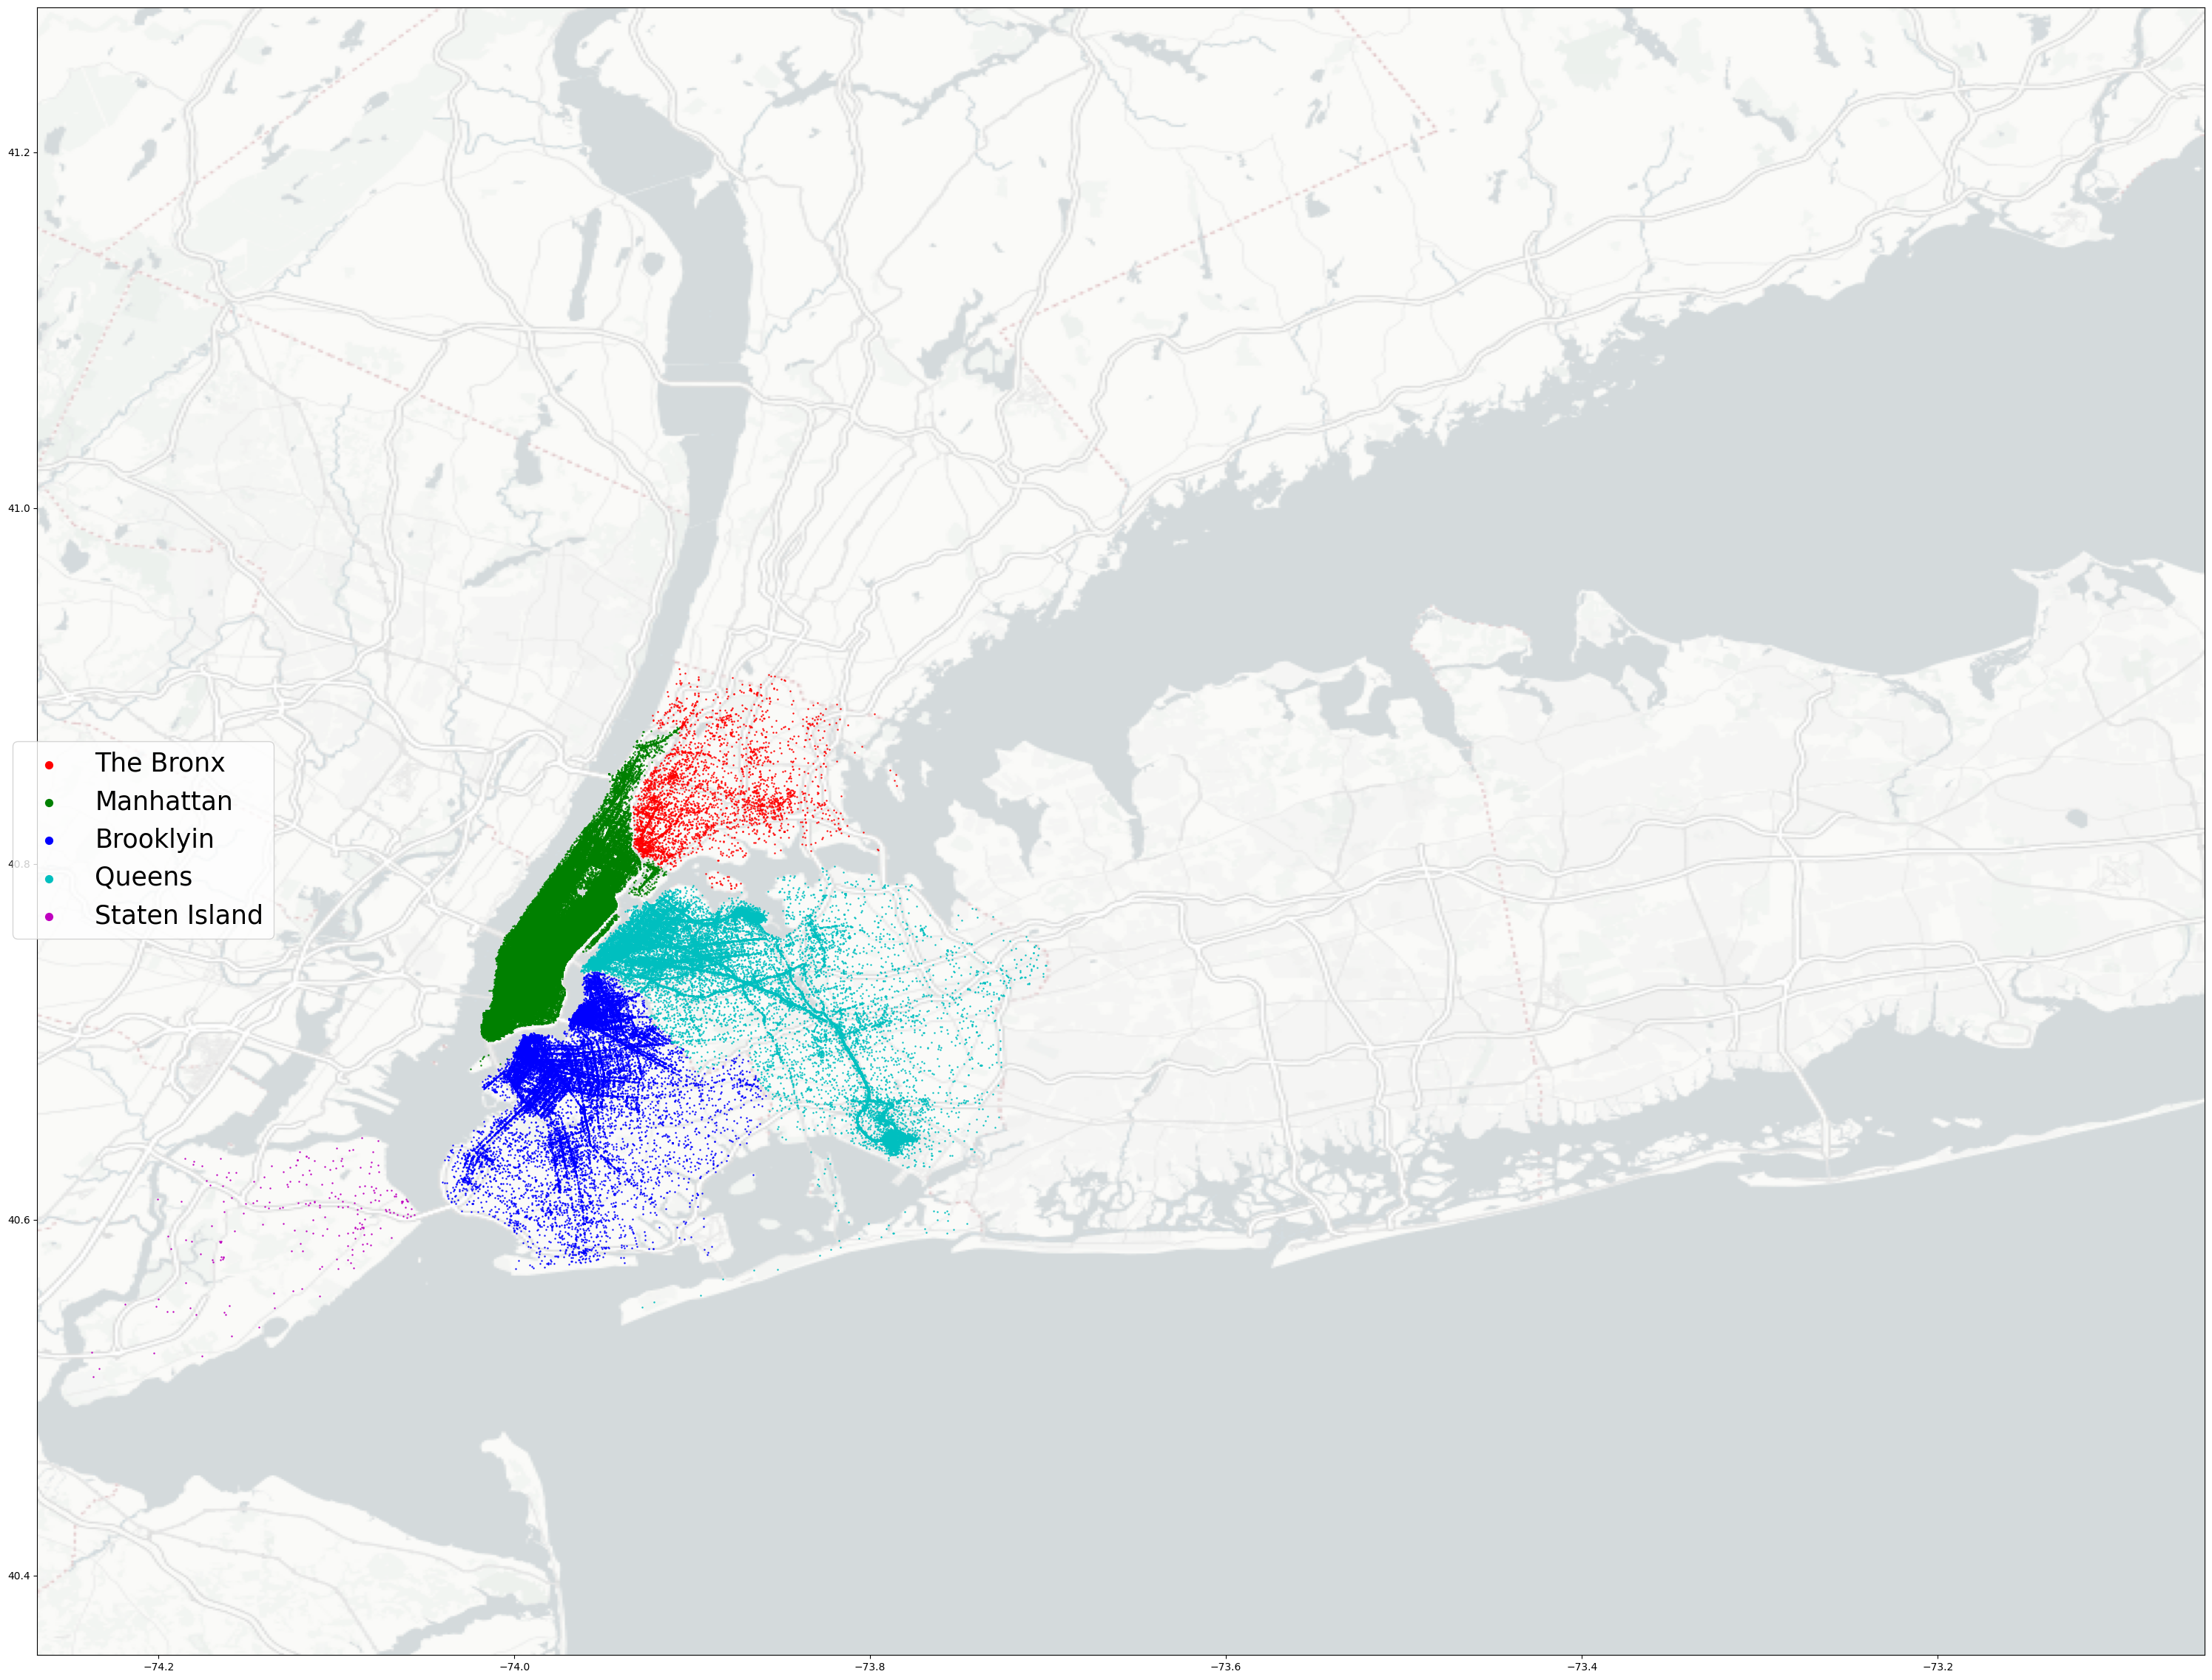

In [15]:
fig, ax = plt.subplots(1, figsize=(30, 30))

for b, color in zip(boros.values(), ['r', 'g', 'b', 'c', 'm', 'y']):
    df_tmp = df.filter(pl.col('pickup_borough') == b['name'])
    print_point_on_map(ax, df_tmp['pickup_longitude'],
                       df_tmp['pickup_latitude'], points_area, image, color=color)
fig.legend(('The Bronx', 'Manhattan', 'Brooklyin', 'Queens', 'Staten Island'),
           fontsize=25, loc='center left', markerscale=10)

plt.tight_layout()
plt.show()

# References
*TODO: properly cite?*

[1]: CARTO basemap styles, https://github.com/CartoDB/basemap-styles

[2]: New York City Neighborhoods, 2007, https://geodata.lib.utexas.edu/catalog/sde-columbia-nycp_2007_nynh